In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery
import astropy.coordinates as coord
import astropy.units as u
import scipy.stats
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
def dust(ra, dec, distance, plot=False, max_samples=10, mode='median', model='bayes'):
    c = coord.SkyCoord(ra*u.deg, dec*u.deg, distance=distance*u.pc)
    sfd = SFDQuery()
    bayes = BayestarQuery(max_samples=max_samples)

    return sfd(c), bayes(c, mode=mode, return_flags=True) #, iphas(c, mode=mode), marshall(c), chen(c)
def getDust(G, bp, rp, ebv, maxnit=100):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1
    print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


In [3]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 2,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.0,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [4]:
query = "SELECT TOP 10000 \
phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source \
WHERE parallax_over_error > 20 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))"

In [5]:
wd_query = "SELECT TOP 1000 \
phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source \
WHERE parallax_over_error > 20 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND bp_rp < 2 \
AND phot_g_mean_mag+5*log10(parallax)-10 > 10+2.6*bp_rp"

In [6]:
from astroquery.gaia import Gaia
job = Gaia.launch_job(wd_query)
data = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Launched query: 'SELECT TOP 1000 phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source WHERE parallax_over_error > 20 AND phot_g_mean_flux_over_error>50 AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND visibility_periods_used>8 AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) AND bp_rp < 2 AND phot_g_mean_mag+5*log10(parallax)-10 > 10+2.6*bp_rp'
Retrieving sync. results...
Query finished.


(17, -2)

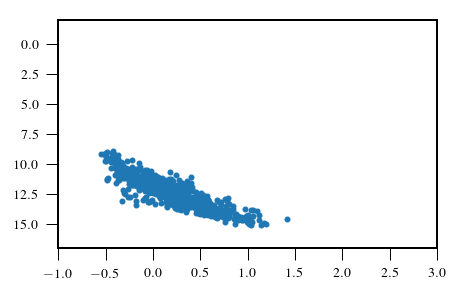

In [7]:
fig, ax1 = plt.subplots()
ax1.scatter(data['bp_rp'], data['mg'])
ax1.set_xlim([-1,3])
ax1.set_ylim([17,-2])

In [8]:
pulsar_data = np.genfromtxt('ipta_3arcsec_wpm-result.csv', 
                            delimiter=',', names=True, dtype=None, encoding=None)

In [9]:
from astropy.table import Table, unique, Column
pulsar_data = Table(pulsar_data)
pulsar_data.sort(['names', 'angdist'])
pulsar_data = unique(pulsar_data, keys='names') # drop less-good duplicate matches

In [10]:
names_keep = ['J0437-4715', 'J1012+5307', 'J1024-0719', 'J1732-5049', 'J1910+1256', 'J1955+2908']
pulsar_data = pulsar_data[np.isin(pulsar_data['names'], names_keep)] # keep only the sources we wrote about

In [11]:
distance =      Column([156.7,  907, 1272, 4220, 1162, 1896], name='distance')
distance_low =  Column([156.5,  777, 1072, 2854,  862, 1496], name='distance_low')
distance_high = Column([156.9, 1037, 1472, 5586, 1462, 2269], name='distance_high')
pulsar_data.add_columns([distance, distance_low, distance_high])

pulsar_data['mg'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['r_est']/1.e3) - 5.
pulsar_data['mg_lo'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['r_hi']/1.e3) - 5.
pulsar_data['mg_hi'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['r_lo']/1.e3) - 5.
mg_err = np.vstack((np.abs(pulsar_data['mg_lo'] - pulsar_data['mg']), 
                    np.abs(pulsar_data['mg_hi'] - pulsar_data['mg'])))


In [19]:
pulsar_data['mg'] = pulsar_data['phot_g_mean_mag']*u.mag - coord.Distance(pulsar_data['distance']*u.pc).distmod
pulsar_data['mg_lo'] = pulsar_data['phot_g_mean_mag']*u.mag - coord.Distance(pulsar_data['distance_high']*u.pc).distmod
pulsar_data['mg_hi'] = pulsar_data['phot_g_mean_mag']*u.mag - coord.Distance(pulsar_data['distance_low']*u.pc).distmod
mg_err = np.vstack((np.abs(pulsar_data['mg_lo'] - pulsar_data['mg']), 
                    np.abs(pulsar_data['mg_hi'] - pulsar_data['mg'])))
color_err = np.sqrt((2.5 / np.log(10)*pulsar_data['phot_bp_mean_flux_error']/pulsar_data['phot_bp_mean_flux'])**2 + 
                    (2.5 / np.log(10)*pulsar_data['phot_rp_mean_flux_error']/pulsar_data['phot_rp_mean_flux'])**2)

pulsar_data['mg'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['distance']/10.)
pulsar_data['mg_lo'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['distance_high']/10.) 
pulsar_data['mg_hi'] = pulsar_data['phot_g_mean_mag'] \
                    - 5.*np.log10(pulsar_data['distance_low']/10.)
mg_err = np.vstack((np.abs(pulsar_data['mg_lo'] - pulsar_data['mg']), 
                    np.abs(pulsar_data['mg_hi'] - pulsar_data['mg'])))
color_err = np.sqrt((2.5 / np.log(10)*pulsar_data['phot_bp_mean_flux_error']/pulsar_data['phot_bp_mean_flux'])**2 + 
                    (2.5 / np.log(10)*pulsar_data['phot_rp_mean_flux_error']/pulsar_data['phot_rp_mean_flux'])**2)

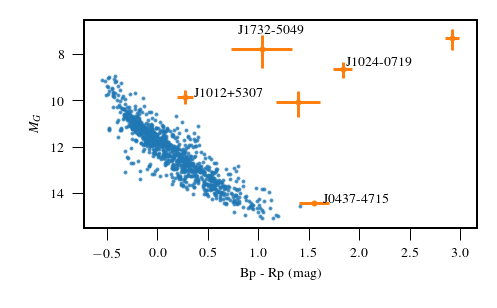

In [30]:
fig, ax1 = plt.subplots()
ax1.scatter(data['bp_rp'], data['mg'], color='C0', alpha=0.7, s=1)
ax1.errorbar(pulsar_data['bp_rp'], pulsar_data['mg'], yerr=mg_err, xerr=color_err, color='C1', fmt='o')
#ax1.set_xlim([-.7,3])
#ax1.set_ylim([22,8])
ax1.invert_yaxis()
ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')
bprp = pulsar_data['bp_rp'] - bestAbp + bestArp
absG = pulsar_data['mg'] - best
for i in range(6):
    ax1.annotate(pulsar_data['names'][i], (bprp[i]+0.1, absG[i]), color = 'black')

#ax1.annotate(pulsar_data['names'][0], (1.25, 21.5), color = 'black')
#ax1.annotate(pulsar_data['names'][1], (-.05, 17), color = 'black')
#ax1.annotate(pulsar_data['names'][2], (1.55,12.5), color = 'black')
#ax1.text(0.7, 11.2, pulsar_data['names'][3], color = 'black', weight = 'heavy')
#ax1.annotate(pulsar_data['names'][4], (1.2,15.2), color = 'black')
#ax1.annotate(pulsar_data['names'][5], (2.3, 14.3), color = 'black')



plt.tight_layout()
plt.savefig("../figures/hrd_wLabels.pdf")

In [16]:
sfd, bayesMid = dust(pulsar_data['ra'], pulsar_data['dec'], pulsar_data['distance'])
sfdAG, sfdAbp, sfdArp = getDust(pulsar_data['phot_g_mean_mag'], pulsar_data['phot_bp_mean_mag'], pulsar_data['phot_rp_mean_mag'], sfd)
bayesAG, bayesAbp, bayesArp = getDust(pulsar_data['phot_g_mean_mag'], pulsar_data['phot_bp_mean_mag'], pulsar_data['phot_rp_mean_mag'], bayesMid[0])

3.7608523851417885e-06
0.0


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


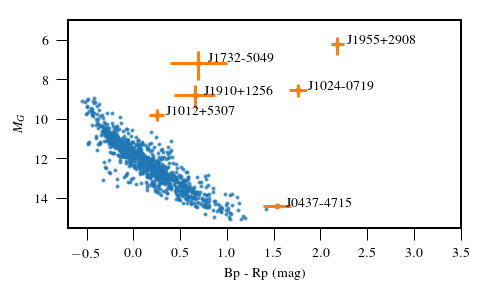

In [25]:
bestAG = bayesAG
bestAG[np.isnan(bestAG)] = sfdAG[np.isnan(bestAG)]
bestArp = bayesArp
bestArp[np.isnan(bestArp)] = sfdArp[np.isnan(bestArp)]
bestAbp = bayesAbp
bestAbp[np.isnan(bestAbp)] = sfdAbp[np.isnan(bestAbp)]
fig, ax1 = plt.subplots()
bprp = pulsar_data['bp_rp'] - bestAbp + bestArp
absG = pulsar_data['mg'] - bestAG
ax1.scatter(data['bp_rp'], data['mg'], color='C0', alpha=0.7, s=1)
ax1.errorbar(pulsar_data['bp_rp'] - bestAbp + bestArp, pulsar_data['mg'] - bestAG, yerr=mg_err, xerr=color_err, color='C1', fmt='o')
ax1.set_xlim([-.7,3.5])
ax1.set_ylim([15.5,5])
#ax1.invert_yaxis()
ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')
#for ii in range(6):
#    ax1.annotate(pulsar_data['names'][ii], (data['bp_rp'][ii], data['mg'][ii]), color = 'black')
for i in range(6):
    ax1.annotate(pulsar_data['names'][i], (bprp[i]+0.1, absG[i]), color = 'black')

plt.tight_layout()
plt.savefig("../figures/hrd_wLabels_wDust.pdf")

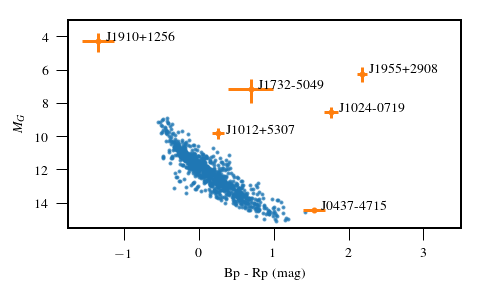

In [28]:
bestAG = sfdAG
bestAG[np.isnan(bestAG)] = bayesAG[np.isnan(bestAG)]
bestArp = sfdArp
bestArp[np.isnan(bestArp)] = bayesArp[np.isnan(bestArp)]
bestAbp = sfdAbp
bestAbp[np.isnan(bestAbp)] = bayesAbp[np.isnan(bestAbp)]
fig, ax1 = plt.subplots()
bprp = pulsar_data['bp_rp'] - bestAbp + bestArp
absG = pulsar_data['mg'] - bestAG
ax1.scatter(data['bp_rp'], data['mg'], color='C0', alpha=0.7, s=1)
ax1.errorbar(bprp, absG, yerr=mg_err, xerr=color_err,color='C1', fmt='o')
ax1.set_xlim([-1.75,3.5])
ax1.set_ylim([15.5,3])
#ax1.invert_yaxis()
ax1.set_xlabel('Bp - Rp (mag)')
ax1.set_ylabel('$M_G$')
for i in range(6):
    ax1.annotate(pulsar_data['names'][i], (bprp[i]+0.1, absG[i]), color = 'black')
plt.tight_layout()
plt.savefig("../figures/hrd_wLabels_wDustSFD.pdf")